## Comparisons for Olimpia

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims
    )

from classes import SatComp_Metric, CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
cosp_dir = 'satcomp/'
plain_dir = 'mnth15runs/'
consp_dir = "conspiracy_stuff/"

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(cosp_dir) and os.path.exists(plain_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
ct_caliop_slf = xr.open_dataset('caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc')
incloud_caliop_slf = xr.open_dataset('caliop_olimpia/incloud_slf_olimpia/incloud_slfs.nc')

In [4]:
os.listdir(cosp_dir)

['20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2',
 '20200327_132118_singleparam_noresm2satcomp_wbf_1_inp_1',
 '20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3',
 '20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1',
 'unused',
 '20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1',
 '20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',
 'CESM2_slfvars']

In [6]:
noresm2 = "20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1"
cesm2 = "CESM2_slfvars"

In [24]:
noresm2_da = xr.open_dataset("%s%s/%s.nc" % (cosp_dir, noresm2, noresm2)).sel(time=slice("2009-06-01","2013-05-01"))
cesm2_da = xr.open_dataset("%s%s/%s.nc" % (cosp_dir, cesm2, cesm2)).sel(time=slice("2009-06-01","2013-05-01"))

In [47]:
mid_mask = np.bitwise_or(noresm2_da['lat']>60, noresm2_da['lat']<-60)
sea_mask = np.bitwise_or(noresm2_da['LANDFRAC'][0,:,:]==1, mid_mask)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


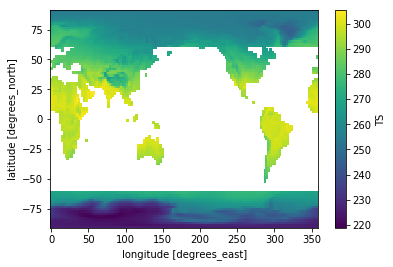

In [48]:
noresm2_da['TS'].where(sea_mask).mean('time').plot()

In [46]:
test1 = noresm2_da["CT_SLF"].where(noresm2_da['lat']>-60 & noresm2_da['lat']<0)

(da['lat'] > lat_lims[0]) & (np.absolute(self.goccp_data['lat'])<82))

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


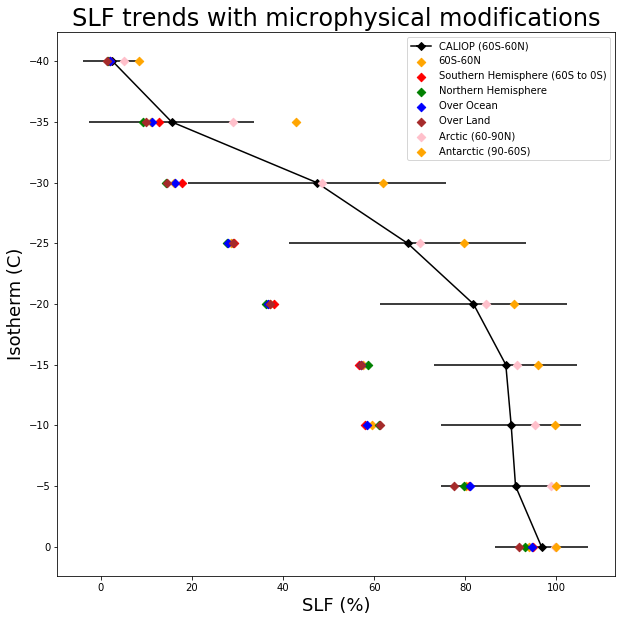

In [55]:
plot_isos(noresm2_da)

In [54]:
def plot_isos(da):
    isos_plot = plt.figure(figsize=[10,10])
    plt.gca().invert_yaxis()

    caliop_weight = ct_caliop_slf['cell_weight']
    caliop_mask = np.bitwise_or(ct_caliop_slf['lat']>60, ct_caliop_slf['lat']<-60)
    caliop_slf = 100*masked_average(ct_caliop_slf['SLF'], dim=['lat','lon'], 
                                    weights=caliop_weight, mask=caliop_mask)
    caliop_stdev = 100*np.std(ct_caliop_slf['SLF'].sel(lat=slice(-60,60)), axis=(0,1))
    _line = plt.errorbar(caliop_slf, caliop_slf['isotherm'], xerr=caliop_stdev, label='CALIOP SLF',
                         fmt='o', color = 'black', zorder=0, linestyle='-', marker='D')

    labels = ['CALIOP (60S-60N)']
    lines = [_line]
    
    colors = ['blue','green','red','orange','purple','yellow', 'pink']
    color = 'blue'
    
    da['CT_SLF'] = da['CT_SLFXCLD_ISOTM']/da['CT_CLD_ISOTM']
    
    da = add_weights(da)
    _weight = da['cell_weight']#*_case['CT_CLD_ISOTM'] #Not sure about this weighting
#     _mask = np.bitwise_or(da['lat']<66.667, da['lat']>82)

    # Cloudtop SLF part
    mid_mask = np.bitwise_or(da['lat']>60, da['lat']<-60)
    da['CT_SLF_TAVG'] = da['CT_SLF'].mean(dim = 'time', skipna=True)
    slf_ct = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=mid_mask)
    err = np.array(slf_ct) - np.array(caliop_slf)
    rms_ct = np.sqrt(np.mean(np.square(err)))

    _line = plt.scatter(slf_ct, slf_ct['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='orange', marker='D')

    labels.append("60S-60N")
    lines.append(_line)
    
    # Check hemispheres:
#     south_mask = da['lat']>0
    south_mask = np.bitwise_or(da['lat']>0, da['lat']<-60)
    
    slf_ct_south = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=south_mask)
    _line = plt.scatter(slf_ct_south, slf_ct_south['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='red', marker='D')
    
    labels.append("Southern Hemisphere (60S to 0S)")
    lines.append(_line) 
    
    north_mask = np.bitwise_or(da['lat']>60, da['lat']<0)    
    slf_ct_north = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=north_mask)
    _line = plt.scatter(slf_ct_north, slf_ct_north['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='green', marker='D')

    labels.append("Northern Hemisphere")
    lines.append(_line)
    
    sea_mask = np.bitwise_or(da['LANDFRAC'][0,:,:]==1, mid_mask)
    slf_ct_sea = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=sea_mask)
    _line = plt.scatter(slf_ct_sea, slf_ct_sea['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='blue', marker='D')

    labels.append("Over Ocean")
    lines.append(_line)
    
    land_mask = np.bitwise_or(da['LANDFRAC'][0,:,:]==0,mid_mask)
    slf_ct_land = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=land_mask)
    _line = plt.scatter(slf_ct_land, slf_ct_land['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='brown', marker='D')

    labels.append("Over Land")
    lines.append(_line)
    
    arctic_mask = da['lat']<60
    slf_ct_arctic = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=arctic_mask)
    _line = plt.scatter(slf_ct_arctic, slf_ct_arctic['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='pink', marker='D')

    labels.append("Arctic (60-90N)")
    lines.append(_line)
    
    antarctic_mask = da['lat']>-60
    slf_ct_antarctic = 100*masked_average(da['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=antarctic_mask)
    _line = plt.scatter(slf_ct_antarctic, slf_ct_antarctic['isotherms_mpc'] - 273.15, 
                        label=("Global "+' RMSE: %.2f' % rms_ct), color='orange', marker='D')

    labels.append("Antarctic (90-60S)")
    lines.append(_line)
#     south = da["CT_SLF"].where(da['lat']>-60 and da['lat']<0)
    
    plt.xlabel('SLF (%)', fontsize=18)
    plt.ylabel('Isotherm (C)', fontsize=18)
    plt.legend(lines, labels)
    plt.title('SLF trends with microphysical modifications', fontsize=24)

In [ ]:
for i,color in zip(self.cases, self.colors):
    _run = self.cases[i]
    _case = _run.case_da
    _weight = _case['cell_weight']#*_case['CT_CLD_ISOTM'] #Not sure about this weighting
    _mask = np.bitwise_or(_case['lat']<66.667, _case['lat']>82)

    # Cloudtop SLF part
    _case['CT_SLF_TAVG'] = _case['CT_SLF'].mean(dim = 'time', skipna=True)
    slf_ct = 100*masked_average(_case['CT_SLF_TAVG'], dim=['lat','lon'], weights=_weight, mask=_mask)
    err = np.array(slf_ct) - np.array(caliop_slf)
    rms_ct = np.sqrt(np.mean(np.square(err)))

    _line = plt.scatter(slf_ct, slf_ct['isotherms_mpc'] - 273.15, 
                        label=(_run.label+' RMSE: %.2f' % rms_ct), color=color, marker='D')

    # Bulk SLF part
    _case['SLF_ISOTM'] = (_case['SLFXCLD_ISOTM'] / _case['CLD_ISOTM'])
    slf_bulk = 100*masked_average(_case['SLF_ISOTM'], dim=['lat','lon', 'time'], weights=_weight, mask=_mask)
    err = np.array(slf_bulk) - np.array(ic_caliop_slf)       
    rms_bulk = np.sqrt(np.mean(np.square(err)))

    plt.scatter(slf_bulk, slf_bulk['isotherms_mpc'] - 273.15, 
                label=(_run.label+' RMSE: %.2f' % rms_bulk), color=color)
    labels.append(_run.label+' CT_RMSE: %.2f, Bulk_RMSE: %.2f' % (rms_ct, rms_bulk))
    lines.append(_line)

plt.xlabel('SLF (%)', fontsize=18)
plt.ylabel('Isotherm (C)', fontsize=18)
plt.legend(lines, labels)
plt.title('SLF trends with microphysical modifications', fontsize=24)

## TRASH?

In [ ]:
# Plot satellite phase retrievals
#     ic_caliop_weight = incloud_caliop_slf['cell_weight']
#     ic_caliop_mask = np.bitwise_or(incloud_caliop_slf['lat']<66.667, 
#                                    incloud_caliop_slf['lat']>82)
#     ic_caliop_slf = 100*masked_average(incloud_caliop_slf['SLF'], dim=['lat','lon'],
#                                        weights=ic_caliop_weight, mask=ic_caliop_mask)
#     ic_caliop_stdev = 100*np.std(incloud_caliop_slf['SLF'].sel(lat=slice(66.667,90)), axis=(0,1))
#     plt.errorbar(ic_caliop_slf, ic_caliop_slf['isotherm'], xerr=ic_caliop_stdev, 
#                  label='CALIOP SLF IC', fmt='o-', color = 'black', zorder=0)

# Bulk SLF part
#     da['SLF_ISOTM'] = (da['SLFXCLD_ISOTM'] / da['CLD_ISOTM'])
#     slf_bulk = 100*masked_average(da['SLF_ISOTM'], dim=['lat','lon', 'time'], weights=_weight, mask=_mask)
#     err = np.array(slf_bulk) - np.array(ic_caliop_slf)       
#     rms_bulk = np.sqrt(np.mean(np.square(err)))

#     plt.scatter(slf_bulk, slf_bulk['isotherms_mpc'] - 273.15, 
#                 label=("Global "+' RMSE: %.2f' % rms_bulk), color=color)